In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fire_model.ca import FireEnv
from dataclasses import dataclass
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import CAFireModel
from fire_model.bo_sr import RetardantDropBayesOptSR, TiedSRDeltaMatern
from fire_model.bo import expected_improvement

# =========================
# Evidence links (used below)
# =========================
# Vic slope rule-of-thumb (CFA Victoria): fire doubles speed for every 10° upslope (and halves downhill).
# https://www.cfa.vic.gov.au/plan-prepare/bushfire-basics/how-fire-behaves
#
# Extreme-day spread rates used as calibration targets (Tolhurst 2009, PHOENIX RapidFire modelling):
# “as fast as 60 km/h in grassland and 40 km/h in forest” (short pulses).
# https://exposed.net.au/tolhurst_2009.pdf
#
# Wind change (“cool change”) context (Australia):
# https://www.sbs.com.au/news/article/whats-the-weather-after-the-heatwave/rhbhojy2l
#
# Barriers like roads/lines can partially stop spread (NWCG S-290 workbook mentions “barriers”).
# https://training.nwcg.gov/dl/s290/s-290-student-workbook-all.pdf
#
# Retardant persistence (manufacturer): effective until a significant rain event.
# https://www.perimeter-solutions.com/en/phos-chek-wildfire-home-defense-faqs/
#
# Drop footprint example (USAF MAFFS): ~1/4 mile long, ~60 ft wide.
# https://www.af.mil/About-Us/Fact-Sheets/Display/Article/104558/modular-airborne-fire-fighting-system/

# ==========================================================
# IMPORTANT: "use slope correctly" requires a tiny model patch
# ==========================================================
# Patch your FireModel step_batch (in fire_model/ca.py) to multiply bias by a slope factor:
#
#   if env.slope is not None:
#       sxg = env.slope[..., 0]   # dz/dx (dimensionless grade)
#       syg = env.slope[..., 1]   # dz/dy
#       grade_along = sxg * ux + syg * uy
#       theta = np.arctan(grade_along) * 180.0 / np.pi
#       theta = np.clip(theta, -30.0, 30.0)
#       slope_factor = np.power(2.0, theta / 10.0)  # CFA: *2 per +10°, /2 per -10°
#       bias *= slope_factor

# =========================
# Scenario: Victoria-style
# =========================
nx = ny = 150
domain_km = 3.0
extent_km = domain_km / 2
dx_m = (domain_km / nx) * 1000.0

xs = np.linspace(-extent_km, extent_km, nx)[:, None]
ys = np.linspace(-extent_km, extent_km, ny)[None, :]
X = xs.repeat(ny, axis=1)
Y = ys.repeat(nx, axis=0)

rng = np.random.default_rng(11)

# ==========================================================
# Common helpers + defaults (kept constant across scenarios)
# ==========================================================
def distance_to_curve(X, Y, pts):
    dmin = np.full(X.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((X - px) ** 2 + (Y - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin

def smooth_noise(rng, nx, ny, iters=6):
    a = rng.normal(size=(nx, ny))
    for _ in range(iters):
        a = (
            0.40 * a
            + 0.10 * np.roll(a, 1, 0) + 0.10 * np.roll(a, -1, 0)
            + 0.10 * np.roll(a, 1, 1) + 0.10 * np.roll(a, -1, 1)
            + 0.05 * np.roll(np.roll(a, 1, 0), 1, 1)
            + 0.05 * np.roll(np.roll(a, -1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(a, 1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(a, -1, 0), 1, 1)
        )
    return (a - a.mean()) / (a.std() + 1e-9)

def make_base_grids(nx=150, ny=150, domain_km=3.0):
    extent_km = domain_km / 2
    xs = np.linspace(-extent_km, extent_km, nx)[:, None]
    ys = np.linspace(-extent_km, extent_km, ny)[None, :]
    X = xs.repeat(ny, axis=1)
    Y = ys.repeat(nx, axis=0)
    dx_m = (domain_km / nx) * 1000.0
    return xs, ys, X, Y, dx_m

def constant_wind(nx, ny, u=12.0, v=3.0):
    # Constant wind (no dir change) so your plot_env works without special handling.
    # Shape: (T, nx, ny, 2) because your plot_env expects time dimension.
    T = 200  # arbitrary timeline length for plotting
    w = np.zeros((T, nx, ny, 2), dtype=float)
    w[..., 0] = u
    w[..., 1] = v
    return w, T // 2  # phase1_steps is only used for snapshot indices

# -----------------------------------
# Helper: distance-to-polyline (sampled)
# -----------------------------------
def distance_to_curve(xgrid, ygrid, pts):
    dmin = np.full(xgrid.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((xgrid - px) ** 2 + (ygrid - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin

# ==========================================================
# 1) Terrain: valley + gentle hills + stochastic relief
# ==========================================================
raw = rng.normal(size=(nx, ny))
smooth = raw.copy()
for _ in range(6):
    smooth = (
        0.40 * smooth
        + 0.10 * np.roll(smooth, 1, 0) + 0.10 * np.roll(smooth, -1, 0)
        + 0.10 * np.roll(smooth, 1, 1) + 0.10 * np.roll(smooth, -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), 1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), -1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), 1, 1)
    )
smooth = (smooth - smooth.mean()) / (smooth.std() + 1e-9)

valley = -95.0 * np.exp(-((Y + 0.05) ** 2) / 0.35)
upland = 65.0 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
west_rise = 40.0 * (1.0 / (1.0 + np.exp((X - 0.3) / 0.55)))  # higher to the west

elev_m = 190.0 + valley + upland + west_rise + 18.0 * smooth
elev_m = np.clip(elev_m, 80.0, 360.0)

# ==========================================================
# 2) River (vertical squiggly)
# ==========================================================
rt = np.linspace(-extent_km, extent_km, 260)
river_x0 = -0.45
river_x = river_x0 + 0.22 * np.sin(0.75 * rt) + 0.08 * np.sin(2.3 * rt)
river_y = rt
river_pts = np.stack([river_x, river_y], axis=1)
d_river = distance_to_curve(X, Y, river_pts)

river_mask = d_river < 0.035
riparian_mask = d_river < 0.095

elev_m = elev_m - 14.0 * np.exp(-(d_river**2) / (2 * 0.030**2))
elev_m = np.clip(elev_m, 70.0, 360.0)

# Slope
dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

# ==========================================================
# 3) Two main towns (as before)
# ==========================================================
flat = slope_deg < 6.0
not_water = ~river_mask

cand0 = flat & not_water & (np.abs(Y) < 0.85) & (d_river > 0.07) & (d_river < 0.20) & (X < 0.5)
cand1 = flat & not_water & (np.abs(Y) < 0.90) & (d_river > 0.35) & (X > 0.6)

def pick_town(mask, prefer_x, prefer_y=0.0):
    score = mask.astype(float)
    score *= np.exp(-(slope_deg**2) / (2 * 4.0**2))
    score *= np.exp(-((Y - prefer_y)**2) / (2 * 0.60**2))
    score *= np.exp(-((X - prefer_x)**2) / (2 * 0.80**2))
    i, j = np.unravel_index(np.argmax(score), score.shape)
    return (i, j)

town0 = pick_town(cand0, prefer_x=-0.2, prefer_y=0.1)   # near river
town1 = pick_town(cand1, prefer_x=+0.5 * extent_km, prefer_y=-0.1)  # east valley terrace

# ==========================================================
# 4) Roads
ROAD_FUEL_FACTOR = 0.10  # roads are burnable but much less likely to carry fire
#    - Main highway E-W
#    - NW feeder now EXTENDS to the map edge (your request)
#    - Two short town connectors
# ==========================================================
t = np.linspace(-extent_km, extent_km, 260)
hw_pts = np.stack([t, -0.10 + 0.22 * np.sin(0.55 * t)], axis=1)
d_hw = distance_to_curve(X, Y, hw_pts)

# Junction on highway west of river
junction_x = river_x0 - 0.55
k_j = int(np.argmin(np.abs(hw_pts[:, 0] - junction_x)))
junction = hw_pts[k_j]

# NW feeder: explicitly runs from TOP-LEFT edge down to the junction (full extent)
# Start at (x=-extent_km, y=+extent_km) which is the top-left boundary in our coord system.
s = np.linspace(0.0, 1.0, 340)
nw_start = np.array([-extent_km, extent_km])
feeder = (1 - s)[:, None] * nw_start + s[:, None] * junction
feeder[:, 1] += 0.24 * np.sin(np.pi * s)  # gentle curve
d_feeder = distance_to_curve(X, Y, feeder)

def nearest_point(poly_pts, p):
    d = np.sqrt((poly_pts[:, 0] - p[0]) ** 2 + (poly_pts[:, 1] - p[1]) ** 2)
    return poly_pts[int(np.argmin(d))]

def connector(town_xy, hw_pts, bend_sign, n=160):
    hx, hy = nearest_point(hw_pts, town_xy)
    s = np.linspace(0.0, 1.0, n)
    x = (1 - s) * town_xy[0] + s * hx
    y = (1 - s) * town_xy[1] + s * hy + 0.10 * np.sin(np.pi * s) * bend_sign
    return np.stack([x, y], axis=1)

town0_xy = (xs[town0[0], 0], ys[0, town0[1]])
town1_xy = (xs[town1[0], 0], ys[0, town1[1]])

conn0 = connector(town0_xy, hw_pts, bend_sign=+1.0)
conn1 = connector(town1_xy, hw_pts, bend_sign=-1.0)
d_conn0 = distance_to_curve(X, Y, conn0)
d_conn1 = distance_to_curve(X, Y, conn1)

road_mask = (d_hw < 0.045) | (d_feeder < 0.040) | (d_conn0 < 0.030) | (d_conn1 < 0.030)

# ==========================================================
# 5) Add a small town near the LEFT road (NW feeder)
#    - Small settlement along the feeder, flat-ish, not on river.
# ==========================================================
# Pick candidate pixels near feeder, away from junction, away from river, and relatively flat.
near_feeder = (d_feeder > 0.02) & (d_feeder < 0.10)
away_from_junction = np.sqrt((X - junction[0])**2 + (Y - junction[1])**2) > 0.9
cand_small = flat & not_water & near_feeder & away_from_junction & (X < -1.4) & (Y > 0.6)

small_town = pick_town(cand_small, prefer_x=(-2.2 / 3.2) * extent_km, prefer_y=0.5 * extent_km)

# Flatten pads for all towns (built environments)
for (ti, tj) in [town0, town1, small_town]:
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    pad = np.exp(-r2 / (2 * 0.18**2))
    elev_m = (1.0 - 0.60 * pad) * elev_m + (0.60 * pad) * elev_m[ti, tj]

# Recompute slope after flattening
dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

town_centers = [town0, town1, small_town]

# ==========================================================
# 6) Fuels
# ==========================================================
fuel = 0.85 * np.ones((nx, ny), dtype=float)
upland_fuel = 1.05 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
fuel += upland_fuel

patch = rng.normal(size=(nx, ny))
for _ in range(4):
    patch = 0.60 * patch + 0.10 * np.roll(patch, 1, 0) + 0.10 * np.roll(patch, -1, 0) + 0.10 * np.roll(patch, 1, 1) + 0.10 * np.roll(patch, -1, 1)
patch = (patch - patch.mean()) / (patch.std() + 1e-9)
fuel *= (1.0 + 0.08 * patch)

# Roads reduce fuel (barrier effect).
# Evidence: barriers can partially stop spread (NWCG S-290).
# https://training.nwcg.gov/dl/s290/s-290-student-workbook-all.pdf
fuel *= np.where(road_mask, ROAD_FUEL_FACTOR, 1.0)
fuel *= np.where(river_mask, 0.05, 1.0)
fuel *= np.where(riparian_mask & (~river_mask), 0.75, 1.0)
fuel = np.clip(fuel, 0.05, 3.10)
# Make hard barriers truly non-burnable
nonburnable = river_mask  # add riparian_mask too if you want it non-burnable
fuel[nonburnable] = 0.0

# ==========================================================
# 7) Values-at-risk (town0 slightly bigger; small town modest)
# ==========================================================
value = np.ones((nx, ny), dtype=float)

def add_town_value(center, core_amp, core_sigma, wui_amp, wui_sigma):
    ti, tj = center
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    return core_amp * np.exp(-r2 / core_sigma) + wui_amp * np.exp(-r2 / wui_sigma)

# Town 0 (near river): slightly bigger / higher value
value += add_town_value(town0, core_amp=11.0, core_sigma=0.085, wui_amp=3.2, wui_sigma=0.26)
# Town 1
value += add_town_value(town1, core_amp=8.0, core_sigma=0.08, wui_amp=3.0, wui_sigma=0.25)
# Small town near feeder: modest
value += add_town_value(small_town, core_amp=5.5, core_sigma=0.07, wui_amp=2.0, wui_sigma=0.20)

value += 0.8 * road_mask.astype(float)
value += 1.2 * (riparian_mask & (~river_mask)).astype(float)

# ==========================================================
# 8) Wind: NW prefrontal + SW cool change
# ==========================================================
# Wind change evidence context:
# https://www.sbs.com.au/news/article/whats-the-weather-after-the-heatwave/rhbhojy2l
#
# NOTE: wind_coeff has units 1/(m/s) in your model form: bias = 1 + wind_coeff * max(0, align)
dt_s = 10.0
T_hours = 6.0
num_steps = int(T_hours * 3600 / dt_s)

wind = np.zeros((num_steps, nx, ny, 2), dtype=float)

phase1_steps = int(4.0 * 3600 / dt_s)
w1 = 15.0
wind[:phase1_steps, ..., 0] = +w1 / np.sqrt(2)
wind[:phase1_steps, ..., 1] = -w1 / np.sqrt(2)

w2 = 12.0
wind[phase1_steps:, ..., 0] = +w2 / np.sqrt(2)
wind[phase1_steps:, ..., 1] = +w2 / np.sqrt(2)

gust = rng.normal(0.0, 1.0, size=(num_steps, 1, 1, 2))
wind *= (1.0 + 0.10 * gust)
wind = np.clip(wind, -25.0, 25.0)

# ==========================================================
# 9) Retardant + ROS
# ==========================================================
# Retardant persistence evidence: effective until significant rain event.
# https://www.perimeter-solutions.com/en/phos-chek-wildfire-home-defense-faqs/
#
# MAFFS footprint example: ~1/4 mile long (~0.4 km), ~60 ft wide (~18 m)
# https://www.af.mil/About-Us/Fact-Sheets/Display/Article/104558/modular-airborne-fire-fighting-system/
drop_w_km = 0.04

drop_h_km = 0.40

# Tolhurst calibration targets:
# https://exposed.net.au/tolhurst_2009.pdf
realistic_env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    slope=slope,  # <-- only affects spread if you applied the slope patchs
    dt_s=dt_s,

    burn_time_s0=900.0,

    retardant_half_life_s=172800.0,
    retardant_k=20.0,

    drop_w_km=drop_w_km,
    drop_h_km=drop_h_km,
    drop_amount=2.0,

    ros_mps=0.06,
    wind_coeff=0.04,

    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.1,

    ros_future_jitter_frac=0.05,
    wind_coeff_future_jitter_frac=0.005,
)


### Visualization & Evaluation Helpers

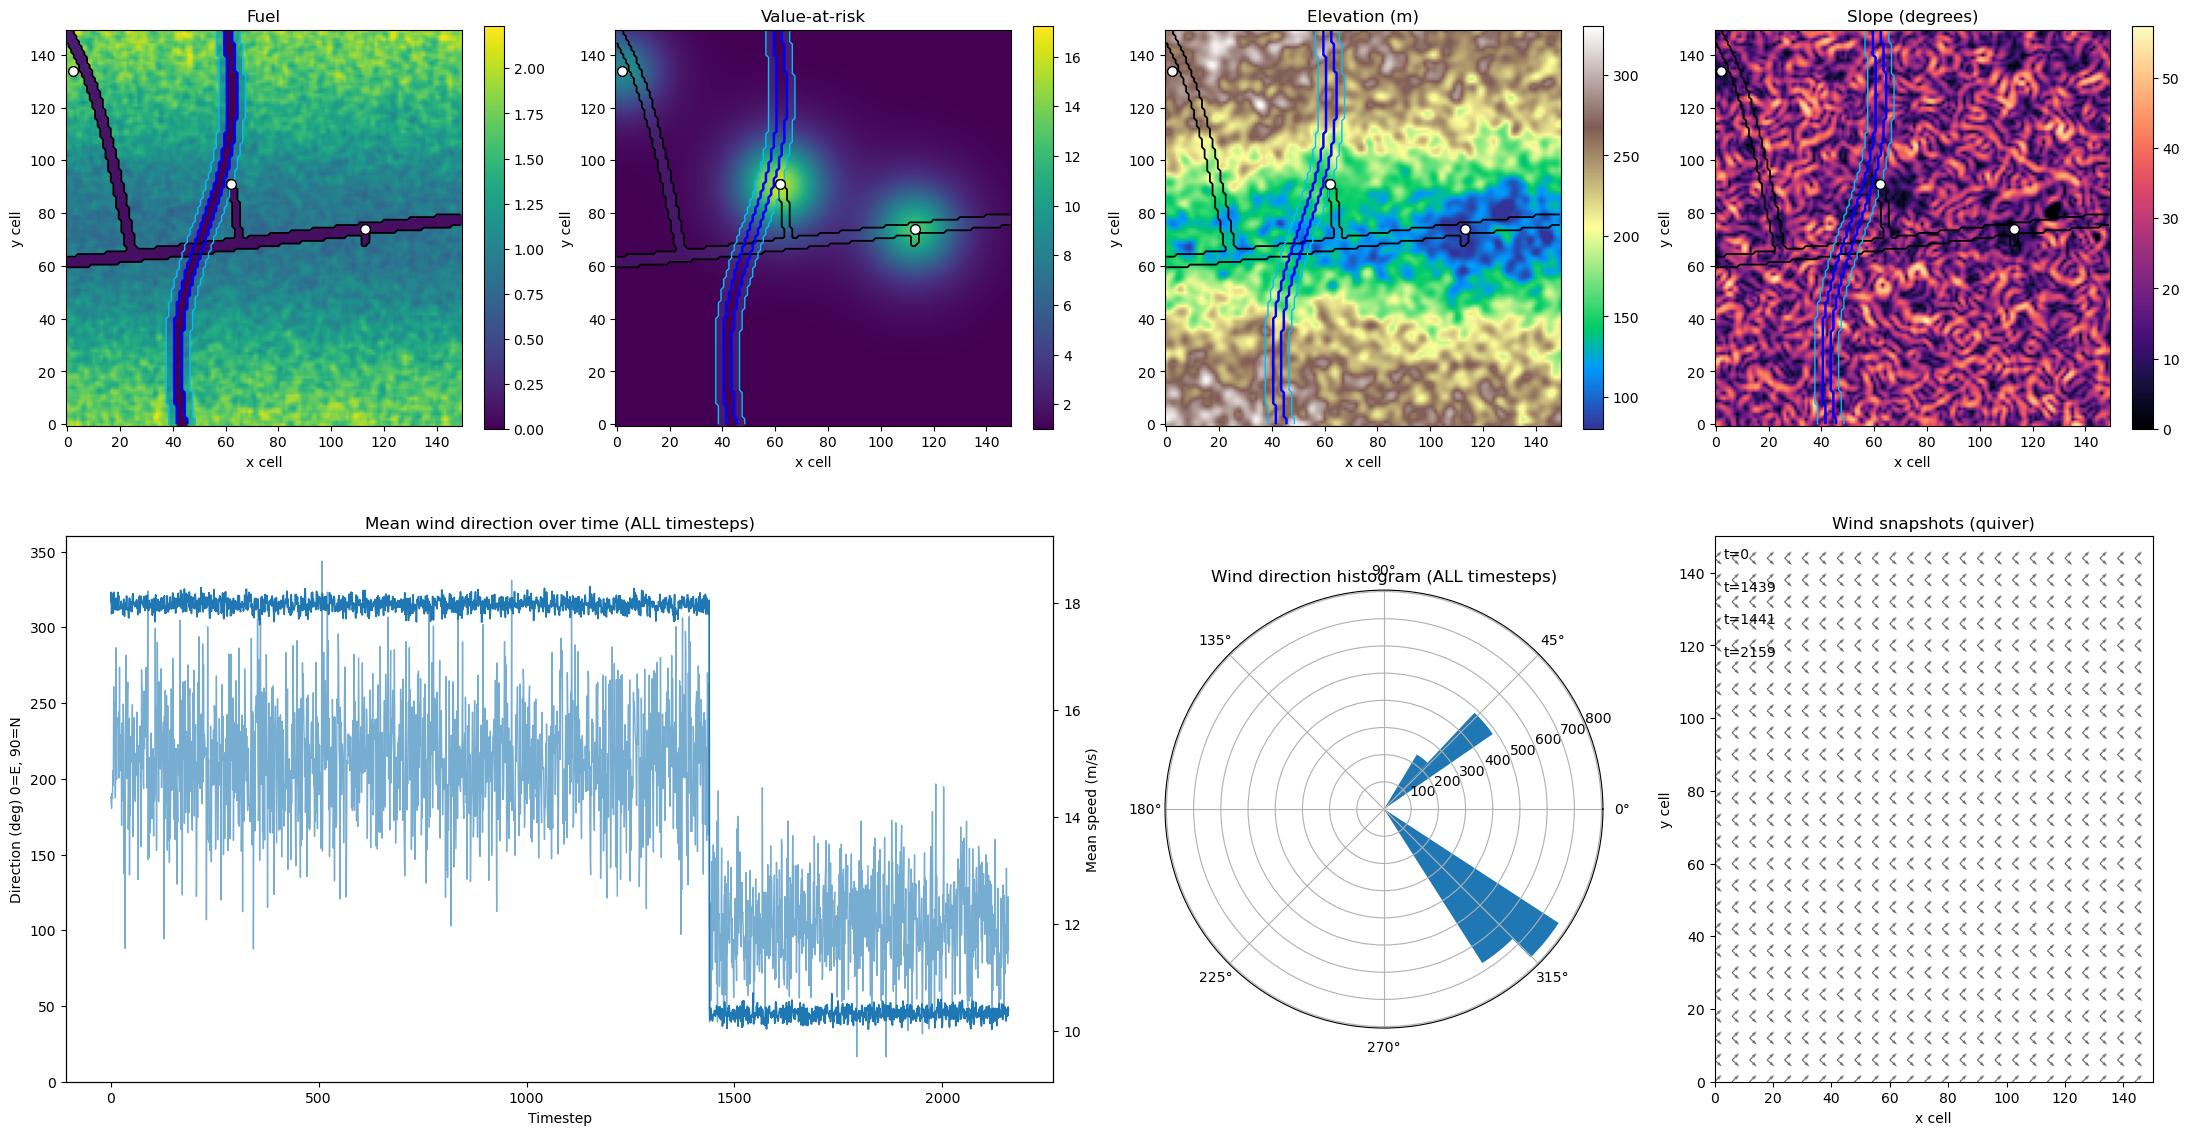

In [2]:

# ==========================================================
# Visualisation (river clearly visible)
# ==========================================================
def plot_env(env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask, phase1_steps):
    fuel = np.asarray(env.fuel, float)
    value = np.asarray(env.value, float)
    wind = np.asarray(env.wind, float)

    slope = np.asarray(slope)
    slope_deg = np.degrees(np.arctan(np.sqrt(slope[..., 0] ** 2 + slope[..., 1] ** 2)))

    mean_vec = wind.reshape(wind.shape[0], -1, 2).mean(axis=1)
    u = mean_vec[:, 0]
    v = mean_vec[:, 1]
    spd = np.sqrt(u**2 + v**2)
    # Math convention: direction vector points TO (0°=East, 90°=North)
    wdir = (np.degrees(np.arctan2(v, u)) + 360.0) % 360.0

    snaps = [0, max(0, phase1_steps - 1), min(len(wdir) - 1, phase1_steps + 1), len(wdir) - 1]
    snaps = sorted(set(snaps))

    fig = plt.figure(figsize=(22, 12))
    gs = fig.add_gridspec(2, 4)

    def overlay(ax):
        # Roads: black contour
        ax.contour(road_mask.T.astype(float), levels=[0.5], linewidths=1.3, colors="k")
        # Riparian: blue dashed
        ax.contour(riparian_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors="deepskyblue")
        # River channel: solid blue
        ax.contour(river_mask.T.astype(float), levels=[0.5], linewidths=1.8, colors="blue")
        for (ti, tj) in town_centers:
            ax.plot(ti, tj, "wo", ms=7, mec="k")
        ax.set_xlabel("x cell")
        ax.set_ylabel("y cell")

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(fuel.T, origin="lower")
    ax.set_title("Fuel")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[0, 1])
    im = ax.imshow(value.T, origin="lower", cmap="viridis")
    ax.set_title("Value-at-risk")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[0, 2])
    im = ax.imshow(elev_m.T, origin="lower", cmap="terrain")
    ax.set_title("Elevation (m)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[0, 3])
    im = ax.imshow(slope_deg.T, origin="lower", cmap="magma")
    ax.set_title("Slope (degrees)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[1, 0:2])
    ax.plot(wdir, lw=1.2)
    ax.set_title("Mean wind direction over time (ALL timesteps)")
    ax.set_ylabel("Direction (deg) 0=E, 90=N")
    ax.set_xlabel("Timestep")
    ax.set_ylim(0, 360)
    ax2 = ax.twinx()
    ax2.plot(spd, lw=1.0, alpha=0.6)
    ax2.set_ylabel("Mean speed (m/s)")

    ax = fig.add_subplot(gs[1, 2], projection="polar")
    ax.hist(np.radians(wdir), bins=24)
    ax.set_title("Wind direction histogram (ALL timesteps)")

    ax = fig.add_subplot(gs[1, 3])
    ax.set_title("Wind snapshots (quiver)")
    skip = max(1, env.grid_size[0] // 22)
    XX = np.arange(0, env.grid_size[0], skip)
    YY = np.arange(0, env.grid_size[1], skip)

    for k, s in enumerate(snaps):
        wf = wind[s][::skip, ::skip]
        ax.quiver(XX, YY, wf[..., 0].T, wf[..., 1].T, alpha=0.35)
        ax.text(0.02, 0.98 - 0.06 * k, f"t={s}", transform=ax.transAxes, va="top")

    ax.set_xlim(0, env.grid_size[0])
    ax.set_ylim(0, env.grid_size[1])
    ax.set_xlabel("x cell")
    ax.set_ylabel("y cell")

    plt.tight_layout()

env_realistic_bundle = realistic_env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask, phase1_steps

plot_env(
    realistic_env,
    elev_m=elev_m,
    slope=slope,
    town_centers=town_centers,
    road_mask=road_mask,
    river_mask=river_mask,
    riparian_mask=riparian_mask,
    phase1_steps=phase1_steps,
)

In [3]:
def pack_env(fuel, value, wind, slope, nx, ny, domain_km, dt_s=10.0):
    return FireEnv(
        grid_size=(nx, ny),
        domain_km=domain_km,
        fuel=fuel,
        value=value,
        wind=wind,
        slope=slope,  
        dt_s=dt_s,
        burn_time_s0=900.0,
        retardant_half_life_s=172800.0,  # long half-life to mimic persistence-until-rain (given exponential decay)
        retardant_k=20.0,
        drop_w_km=0.05,
        drop_h_km=0.60,
        drop_amount=2.0,
        ros_mps=0.05,
        wind_coeff=0.04,
        diag=True,
        avoid_burning_drop=True,
        avoid_drop_p_threshold=0.1,
        ros_future_jitter_frac=0.05,
        wind_coeff_future_jitter_frac=0.005,
    )

In [6]:
@dataclass
class ScenarioBundle:
    name: str
    env: object
    elev_m: np.ndarray
    slope: np.ndarray
    town_centers: list
    road_mask: np.ndarray
    river_mask: np.ndarray
    riparian_mask: np.ndarray
    phase1_steps: int


def bundle_from_tuple(name, t):
    env, elev_m, slope, towns, roads, river, riparian, phase = t
    return ScenarioBundle(
        name=name,
        env=env,
        elev_m=elev_m,
        slope=slope,
        town_centers=towns,
        road_mask=roads,
        river_mask=river,
        riparian_mask=riparian,
        phase1_steps=phase,
    )

SCENARIOS = [
    bundle_from_tuple("Realistic environment", env_realistic_bundle)
]

# ---- fast settings for interactive testing ----
BO_N_INIT = 10
BO_N_ITERS = 40
BO_N_CANDIDATES = 5000
FIDELITY_LOW = 10
FIDELITY_HIGH = 80
DROP_TIME_S = 15 * 60
SEARCH_GRID_EVOLUTION_TIME_S = 60 * 60
EVOLUTION_TIME_S = 60 * 60
IGNITION_RADIUS_KM = 0.25
IGNITION_CENTER_FRAC = (0.42, 0.25)
N_DRONES = 5
FIRE_BOUNDARY_P = 0.25
SEARCH_GRID_K = 200
SEARCH_GRID_BOUNDARY_FIELD = "affected"

# Pick one scenario index to run interactively:
SCENARIO_IDX = 0  # change this (0..len(SCENARIOS)-1)

bundle = SCENARIOS[SCENARIO_IDX]
print("Scenario:", bundle.name)

# --- BO multifidelity (cheap BO, expensive validate) ---
bo_kwargs = dict(
    n_init=BO_N_INIT,
    n_iters=BO_N_ITERS,
    n_candidates=BO_N_CANDIDATES,
    xi=0.03,
    use_ard_kernel=False,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=6,
    candidate_local_sigma_s=0.03,
    candidate_local_sigma_r=0.03,
    candidate_local_sigma_delta_rad=np.deg2rad(9.0),
    candidate_local_resample_delta_prob=0.05,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.2,
    init_heuristic_kwargs={"value_power": 2.4},
    init_heuristic_mix_prob=0.3,
    init_value_r_offset=-0.02,
    init_value_jitter_delta_rad=np.deg2rad(8.0),
    init_uniform_ring_jitter_s=0.15,
    init_uniform_ring_jitter_r=0.05,
    init_downwind_line_wind_bias=3.0,
    init_downwind_line_jitter_r=0.2,
    init_heuristic_value_prob=0.5,
    init_heuristic_uniform_ring_prob=0.0,
    init_heuristic_downwind_prob=0.5,
)


Scenario: Realistic environment


In [5]:
# --- BO setup (SR search, iterative drops, MFBO) ---
fire_model = CAFireModel(bundle.env, seed=0)
nx, ny = bundle.env.grid_size
ignition_center = (int(IGNITION_CENTER_FRAC[0] * nx), int(IGNITION_CENTER_FRAC[1] * ny))
init_firestate = fire_model.init_state_batch(
    n_sims=FIDELITY_HIGH,
    center=ignition_center,
    radius_km=IGNITION_RADIUS_KM,
)

DROP_TIMES_MIN = [10, 20, 30, 40, 50]
DROP_TIMES_S = [t * 60 for t in DROP_TIMES_MIN]
drop_schedule = []
drop_histories = []
drop_y_bests = []

state = init_firestate
t_prev = 0.0
for i, t_drop in enumerate(DROP_TIMES_S):
    # Evolve to drop time using existing retardant (if any)
    dt = float(t_drop - t_prev)
    if dt < 0:
        raise ValueError("DROP_TIMES_S must be non-decreasing.")
    if dt > 0:
        state = fire_model.simulate_from_firestate(
            state,
            T=dt,
            n_sims=FIDELITY_HIGH,
            drone_params=None,
            ros_mps=fire_model.env.ros_mps,
            wind_coeff=fire_model.env.wind_coeff,
            diag=fire_model.env.diag,
            seed=0 + i,
            avoid_burning_drop=fire_model.env.avoid_burning_drop,
            burning_prob_threshold=fire_model.env.avoid_drop_p_threshold,
        )

    remaining = float(max(0.0, EVOLUTION_TIME_S - t_drop))
    if remaining <= 0.0:
        break

    bo = RetardantDropBayesOptSR(
        fire_model=fire_model,
        init_firestate=state,
        n_drones=3,
        evolution_time_s=remaining,
        n_sims=FIDELITY_HIGH,
        fire_boundary_probability=FIRE_BOUNDARY_P,
        search_grid_evolution_time_s=remaining,
    )

    bo.setup_search_grid_sr(
        K=SEARCH_GRID_K,
        boundary_field=SEARCH_GRID_BOUNDARY_FIELD,
        n_r=150,
        smooth_iters=200,
        omega=1.0,
    )

    best_theta, best_params, best_y, history_high, y_nexts, y_bests = bo.run_bayes_opt(
        **bo_kwargs,
        K_grid=SEARCH_GRID_K,
        boundary_field=SEARCH_GRID_BOUNDARY_FIELD,
        n_r=150,
        smooth_iters=200,
        omega=1.0,
        verbose=True,
        use_mfbo=True,
        mf_options=dict(
            low_n_sims=FIDELITY_LOW,
            low_evolution_time_s=0.5 * remaining,
            mf_warmup_low=5,
            mf_low_per_high=2,
            mf_low_cost=0.25,
            mf_high_cost=1.0,
            mf_return_history=False,
        ),
    )
    print(f"[Drop {i+1}] best_y={best_y:.6g}")
    drop_histories.append(history_high)
    drop_y_bests.append(y_bests)

    # Apply retardant at drop time to current state
    params = bo.decode_theta(best_theta)
    fire_model.apply_retardant_cartesian(
        state,
        params,
        drop_w_km=fire_model.env.drop_w_km,
        drop_h_km=fire_model.env.drop_h_km,
        amount=fire_model.env.drop_amount,
        avoid_burning=fire_model.env.avoid_burning_drop,
        burning_prob_threshold=fire_model.env.avoid_drop_p_threshold,
        cell_cap=fire_model.env.retardant_cell_cap,
    )

    drop_schedule.append({"time_s": float(t_drop), "params": params})
    t_prev = float(t_drop)

# Flatten for convenience (each row: x, y, phi)
iterative_params = np.vstack([d["params"] for d in drop_schedule]) if drop_schedule else np.empty((0, 3))


No drone_params
No drone_params


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_fire_evolution_with_context(
    fire_model,
    init_firestate,
    *,
    T_s,
    n_sims,
    drone_params=None,
    dt_snapshot_s=5*60,
    seed=0,
    roads_mask=None,
    river_mask=None,
    riparian_mask=None,
    town_centers=None,
    value_map=None,
    value_contours=(3.0, 6.0, 10.0),
    title="Fire evolution (P(affected)) with context",
    cmap="inferno",
    fire_gamma=0.65,
    fire_interp="bicubic",
    diag=True,
    drop_time_s=0.0,
    drop_schedule=None,
    avoid_burning_drop=None,
    burning_prob_threshold=0.5,
    # --- retardant plotting options ---
    show_retardant=True,
    retardant_alpha=0.35,
    retardant_cmap="magma",
    retardant_contours=(0.3, 0.6, 1.0),
    retardant_vmax=None,
):
    """
    Shows P(affected) over time with contextual overlays AND retardant drops.

    Retardant is shown as:
      - semi-transparent heatmap
      - optional contour lines (to clearly see drop paths)
    """

    env = fire_model.env
    nx, ny = env.grid_size

    # Resolve default drop constraints from env if not supplied
    if avoid_burning_drop is None:
        avoid_burning_drop = getattr(env, "avoid_burning_drop", False)
    if burning_prob_threshold is None:
        burning_prob_threshold = getattr(env, "avoid_drop_p_threshold", 0.25)

    # Snapshot times
    times = np.arange(0, T_s + 1e-9, dt_snapshot_s, dtype=float)
    if times[-1] < T_s:
        times = np.append(times, T_s)

    min_drop_time = None
    if drop_schedule is not None and len(drop_schedule) > 0:
        min_drop_time = min(float(d["time_s"]) for d in drop_schedule)
    elif drop_time_s is not None:
        min_drop_time = float(drop_time_s)

    # ---- helpers -------------------------------------------------------------

    def to_p_affected(fs):
        b = np.asarray(fs.burning, float)
        d = np.asarray(fs.burned, float)

        if b.ndim == 3:
            b = b.mean(axis=0)
        if d.ndim == 3:
            d = d.mean(axis=0)

        return np.clip(b + d, 0.0, 1.0)

    def to_retardant_mean(fs):
        if not hasattr(fs, "retardant") or fs.retardant is None:
            return None

        R = np.asarray(fs.retardant, float)
        if R.ndim == 3:
            R = R.mean(axis=0)

        return np.maximum(R, 0.0)

    def overlay_context(ax):
        if roads_mask is not None:
            ax.contour(np.asarray(roads_mask).T.astype(float),
                       levels=[0.5], colors="saddlebrown", linewidths=1.2)

        if riparian_mask is not None:
            ax.contour(np.asarray(riparian_mask).T.astype(float),
                       levels=[0.5], colors="deepskyblue",
                       linewidths=1.0, linestyles="--")

        if river_mask is not None:
            ax.contour(np.asarray(river_mask).T.astype(float),
                       levels=[0.5], colors="blue", linewidths=1.6)

        if town_centers is not None:
            for (ti, tj) in town_centers:
                ax.plot(ti, tj, "wo", ms=7, mec="k", mew=1.0)

        if value_map is not None and value_contours:
            V = np.asarray(value_map, float)
            ax.contour(V.T, levels=list(value_contours),
                       colors="w", linewidths=0.9, alpha=0.8)

        ax.set_xlim(0, nx)
        ax.set_ylim(0, ny)
        ax.set_xlabel("x cell")
        ax.set_ylabel("y cell")

    # ---- figure layout --------------------------------------------------------

    n = len(times)
    ncols = n
    nrows = 1
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(4.8 * ncols + 1.6, 4.8),
        squeeze=False
    )

    # ---- simulate + plot -----------------------------------------------------

    for k, t in enumerate(times):
        r, c = divmod(k, ncols)
        ax = axes[r][c]

        if drop_schedule is not None and len(drop_schedule) > 0:
            # Simulate with multiple drops (each applied at its time)
            state = init_firestate
            t_prev = 0.0
            for drop in sorted(drop_schedule, key=lambda d: d["time_s"]):
                t_drop = float(drop["time_s"])
                if float(t) < t_drop:
                    break
                dt = float(t_drop - t_prev)
                if dt > 0:
                    state = fire_model.simulate_from_firestate(
                        state,
                        T=dt,
                        n_sims=int(n_sims),
                        drone_params=None,
                        ros_mps=env.ros_mps,
                        wind_coeff=env.wind_coeff,
                        diag=diag,
                        seed=seed,
                        avoid_burning_drop=avoid_burning_drop,
                        burning_prob_threshold=burning_prob_threshold,
                    )
                fire_model.apply_retardant_cartesian(
                    state,
                    drop["params"],
                    drop_w_km=env.drop_w_km,
                    drop_h_km=env.drop_h_km,
                    amount=env.drop_amount,
                    avoid_burning=avoid_burning_drop,
                    burning_prob_threshold=burning_prob_threshold,
                    cell_cap=env.retardant_cell_cap,
                )
                t_prev = float(t_drop)
            dt_rem = float(t) - t_prev
            if dt_rem <= 0.0:
                fs = state
            else:
                fs = fire_model.simulate_from_firestate(
                    state,
                    T=dt_rem,
                    n_sims=int(n_sims),
                    drone_params=None,
                    ros_mps=env.ros_mps,
                    wind_coeff=env.wind_coeff,
                    diag=diag,
                    seed=seed,
                    avoid_burning_drop=avoid_burning_drop,
                    burning_prob_threshold=burning_prob_threshold,
                )
            fs = fire_model.simulate_from_firestate(
                state,
                T=dt_rem,
                n_sims=int(n_sims),
                drone_params=None,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
        elif drone_params is None or float(drop_time_s) <= 0.0 or float(t) <= 0.0:
            fs = fire_model.simulate_from_firestate(
                init_firestate,
                T=float(t),
                n_sims=int(n_sims),
                drone_params=drone_params,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
        elif float(t) < float(drop_time_s):
            fs = fire_model.simulate_from_firestate(
                init_firestate,
                T=float(t),
                n_sims=int(n_sims),
                drone_params=None,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
        else:
            pre = fire_model.simulate_from_firestate(
                init_firestate,
                T=float(drop_time_s),
                n_sims=int(n_sims),
                drone_params=None,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
            fs = fire_model.simulate_from_firestate(
                pre,
                T=float(t - drop_time_s),
                n_sims=int(n_sims),
                drone_params=drone_params,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )

        # --- fire ---
        p_aff = to_p_affected(fs)
        fire_norm = mcolors.PowerNorm(gamma=fire_gamma, vmin=0.0, vmax=1.0)
        im = ax.imshow(
            p_aff.T,
            origin="lower",
            norm=fire_norm,
            cmap=cmap,
            interpolation=fire_interp,
        )

        # --- retardant ---
        if show_retardant and (min_drop_time is not None) and float(t) >= float(min_drop_time):
            R = to_retardant_mean(fs)
            if R is not None and np.nanmax(R) > 0:
                vmax = (
                    retardant_vmax
                    if retardant_vmax is not None
                    else float(np.nanmax(R))
                )

                ax.imshow(
                    R.T,
                    origin="lower",
                    cmap=retardant_cmap,
                    vmin=0.0,
                    vmax=vmax,
                    alpha=retardant_alpha,
                )

                if retardant_contours:
                    ax.contour(
                        R.T,
                        levels=list(retardant_contours),
                        colors="white",
                        linewidths=1.0,
                        alpha=0.9,
                    )

        ax.set_title(f"t = {int(t/60)} min" if t >= 60 else f"t = {t:.0f} s")
        overlay_context(ax)

    # Disable unused axes
    for kk in range(n, nrows * ncols):
        r, c = divmod(kk, ncols)
        axes[r][c].axis("off")

    # Shared colorbar (fire)
    fig.subplots_adjust(right=0.86)
    cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("P(affected) = P(burning or burned)")

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.show()


No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


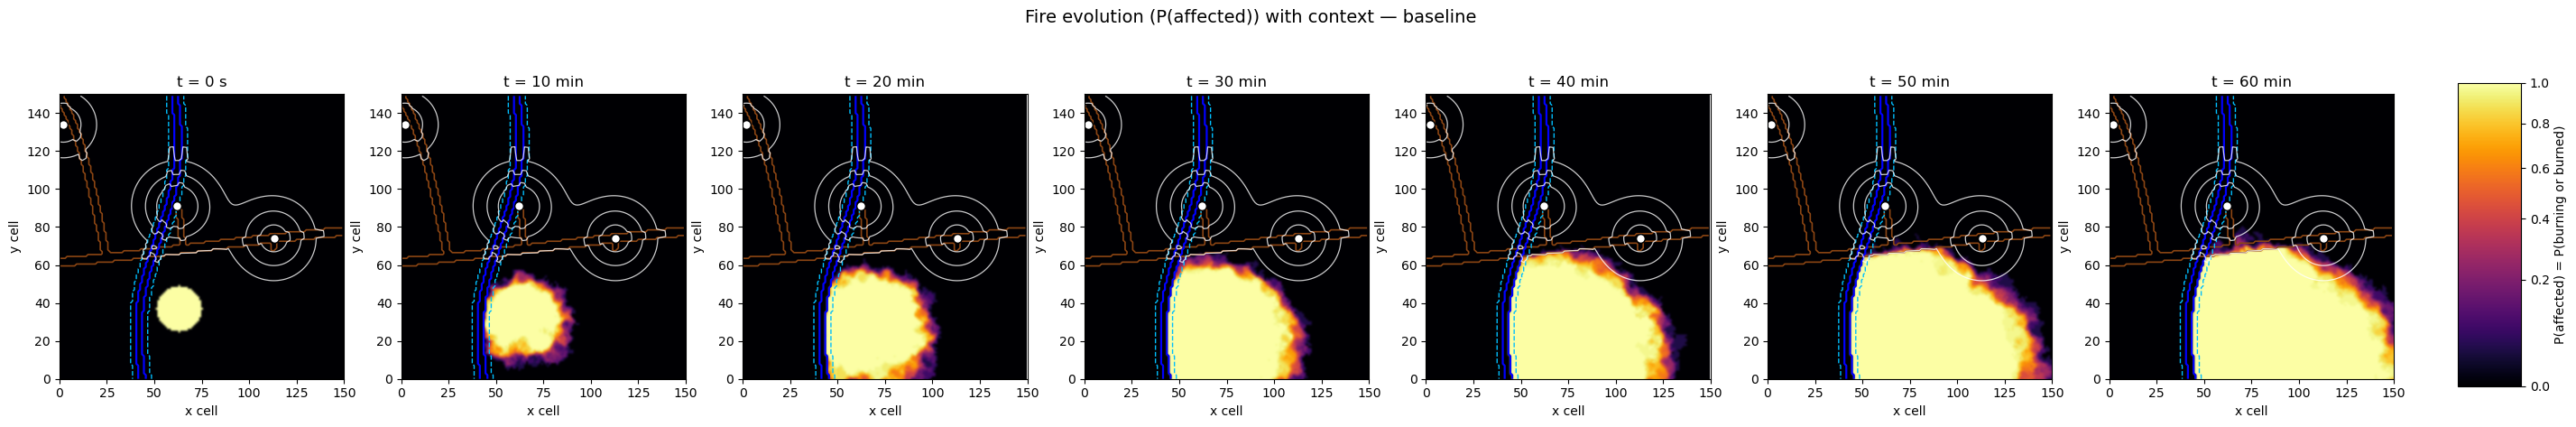

In [ ]:
plot_fire_evolution_with_context(
    fire_model,
    init_firestate,
    T_s=60 * 60,
    n_sims=FIDELITY_HIGH,
    drone_params=None,
    dt_snapshot_s=10.1 * 60,
    seed=1,
    roads_mask=bundle.road_mask,
    river_mask=bundle.river_mask,
    riparian_mask=bundle.riparian_mask,
    town_centers=bundle.town_centers,
    value_map=bundle.env.value,
    diag=bundle.env.diag,
    avoid_burning_drop=bundle.env.avoid_burning_drop,
    burning_prob_threshold=bundle.env.avoid_drop_p_threshold,
    title="Fire evolution (P(affected)) with context — baseline",
)


No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


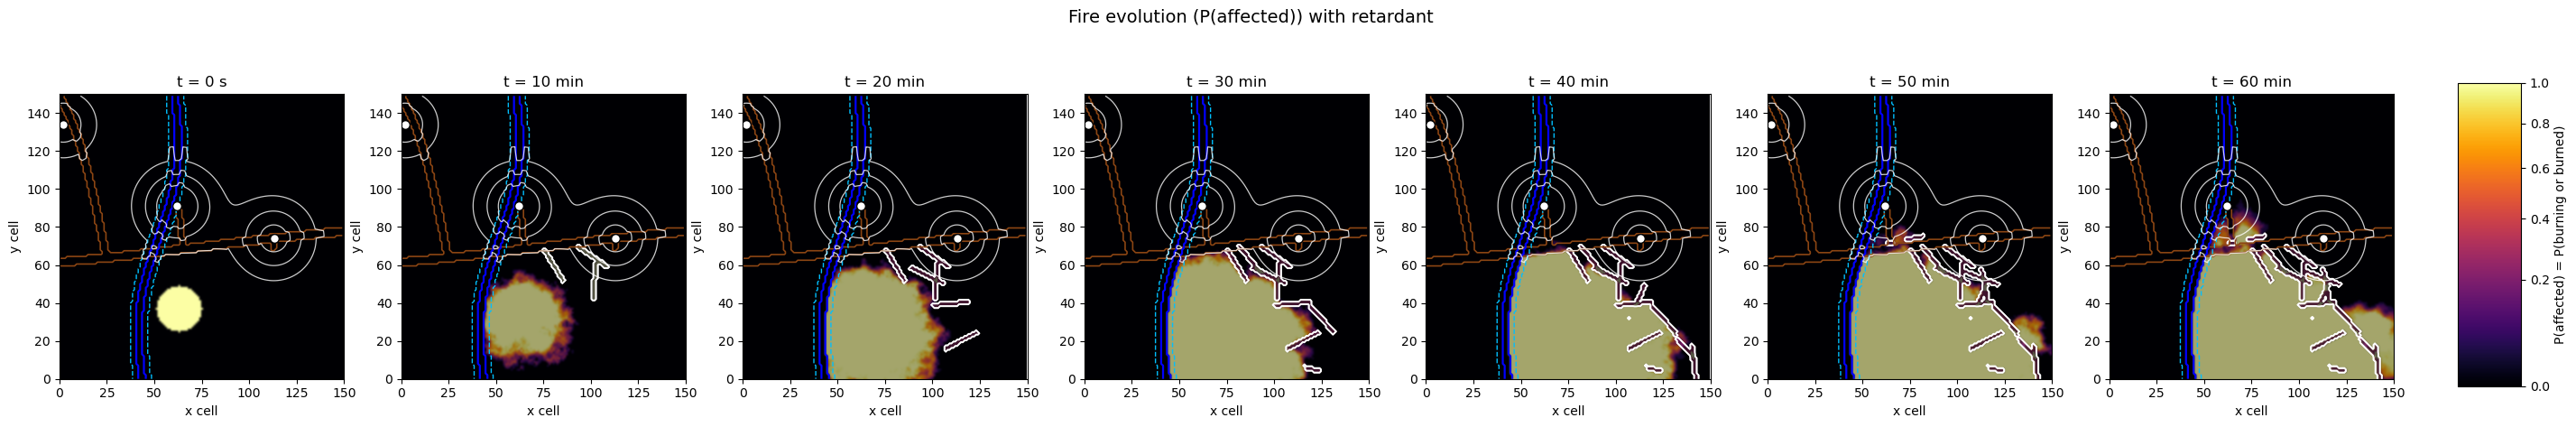

In [ ]:
# --- Plot fire evolution with suppression (retardant placements) ---
plot_fire_evolution_with_context(
    fire_model,
    init_firestate,
    T_s=EVOLUTION_TIME_S,
    n_sims=FIDELITY_HIGH,
    drone_params=None,
    drop_schedule=drop_schedule,
    dt_snapshot_s=10 * 61,
    seed=1,
    roads_mask=bundle.road_mask,
    river_mask=bundle.river_mask,
    riparian_mask=bundle.riparian_mask,
    town_centers=bundle.town_centers,
    value_map=bundle.env.value,
    diag=bundle.env.diag,
    avoid_burning_drop=bundle.env.avoid_burning_drop,
    burning_prob_threshold=bundle.env.avoid_drop_p_threshold,
    title="Fire evolution (P(affected)) with retardant",
)

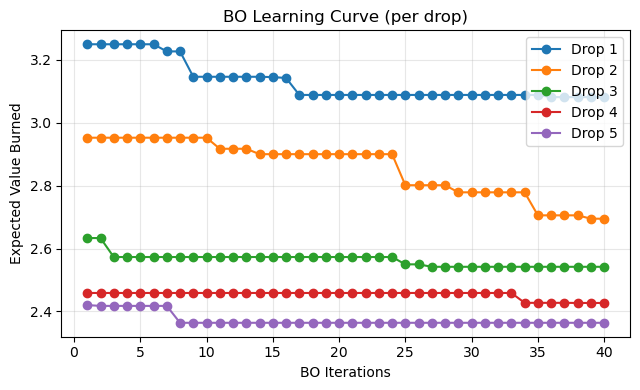

In [ ]:
# --- BO learning curve (per drop) ---
def plot_learning_curve_iterative(drop_y_bests, title="BO Learning Curve (per drop)"):
    fig, ax = plt.subplots(figsize=(6.5, 4))
    y_best_4 = None
    for i, y_bests in enumerate(drop_y_bests, start=1):
        if i == 4:
            y_best_4 = y_bests
        elif i == 5: 
            ax.plot(range(1, len(y_bests) + 1), y_bests, marker="o", label=f"Drop 4")
            ax.plot(range(1, len(y_best_4) + 1), y_best_4, marker="o", label=f"Drop 5")
        else:
            ax.plot(range(1, len(y_bests) + 1), y_bests, marker="o", label=f"Drop {i}")
    ax.set_xlabel("BO Iterations")
    ax.set_ylabel("Expected Value Burned")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curve_iterative(drop_y_bests)
